# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Richard Kocián (xkocia19)_

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from zipfile import ZipFile
import re

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [10]:
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        if not re.match(r".*config\d+_run\d\d\d+\.json", filename):
            print(f"'{filename}' neodpovídá přijatelnému názvu, přeskakuji.")
            continue
        with zf.open(filename, "r") as f:
            data.append(json.load(f))

df = pd.DataFrame(data)
df = df.astype({"configuration": str, "run": int, "runtime": float, "status": str})
df

'log_files/' neodpovídá přijatelnému názvu, přeskakuji.


,configuration,run,runtime,status
0,config6,149,53.733556,SUCCESS
1,config2,16,134.543496,SUCCESS
2,config6,180,117.108040,SUCCESS
3,config4,12,223.763044,SUCCESS
4,config5,193,159.540473,SUCCESS
...,...,...,...,...
1195,config5,95,199.461297,SUCCESS
1196,config5,99,155.491930,SUCCESS
1197,config2,83,125.243690,SUCCESS
1198,config5,153,223.312938,SUCCESS


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

Chybné běhy, běhy (neoznačené jako SUCCESS):
                    run  runtime      status
configuration                               
config1       789   197      0.0    SEGFAULT
              367   184      0.0    SEGFAULT
              758     9   1800.0  TIME LIMIT
              1179  148   1800.0  TIME LIMIT
              1194  145      0.0    SEGFAULT
              99    134   1800.0  TIME LIMIT
              51     62      0.0    SEGFAULT
config2       1113   13   1800.0  TIME LIMIT
              92    142      0.0    SEGFAULT
              104    40   1800.0  TIME LIMIT
config3       800   187      0.0    SEGFAULT
              42     41      0.0    SEGFAULT
              565   166   1800.0  TIME LIMIT
              896   113      0.0    SEGFAULT
              318   184      0.0    SEGFAULT
config4       642    76   1800.0  TIME LIMIT
              381    60      0.0    SEGFAULT
              105    56      0.0    SEGFAULT
              327   110   1800.0  TIME LIMIT
config5   

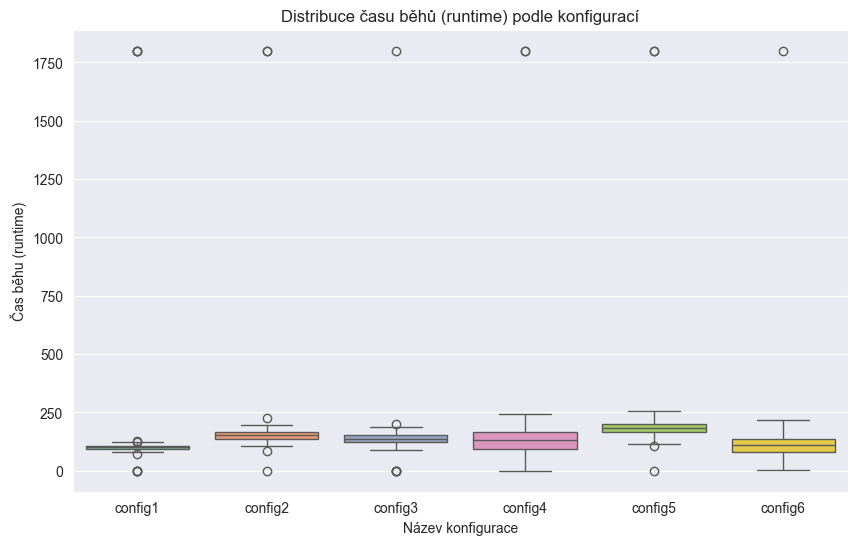

In [11]:
df = df.sort_values(by="configuration")

def not_success_fun(df):
    return df[df["status"] != "SUCCESS"]
not_success = df.groupby("configuration").apply(not_success_fun, include_groups=False)
print("Chybné běhy, běhy (neoznačené jako SUCCESS):")
print(not_success)
print("\n")

# Detekce odlehlých hodnot pomocí interkvartilového rozpětí (IQR)
def detect_outliers(df):
    Q1 = df["runtime"].quantile(0.25)
    Q3 = df["runtime"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df["runtime"] < lower_bound) | (df["runtime"] > upper_bound)]

df_success = df[df['status'] == 'SUCCESS']
outliers = df_success.groupby("configuration").apply(detect_outliers, include_groups=False)
print("Chybné běhy jako odlehlé hodnoty pro jednotlivé běhy konfigurací, které byly ozančeny jako SUCCESS:")
print(outliers)

plt.figure(figsize=(10, 6))
sns.boxplot(x="configuration", y="runtime", data=df, palette="Set2", hue="configuration")
plt.title("Distribuce času běhů (runtime) podle konfigurací")
plt.xlabel("Název konfigurace")
plt.ylabel("Čas běhu (runtime)")
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_

- Chybné hodnoty jsou běhy, které nejsou označeny jako success. Další chybné hodnoty jsou tzv. outliers jednotlivých konfigurací. V grafu se jedná o kolečka. Jsou to běhy konfigurací, které jsou buď za vrchní hranicí (qartil Q3 + 1,5 * IQR) nebo pod spodní hranicí (kvartil Q1 - 1,5 * IQR). IQR je Interquartile Range (rozmezí od Q1 (25. percentil) do Q3 (75. percentil)).

- Tyto chybné hodnoty zde jsou kvůli tomu, že běhy konfigurací obsahují i běhy se statusem "TIME LIMIT" a běhy se statusem "SEGFAULT". Zároveň i v běhách "SUCCESS" se některé chybné hodnoty nacházejí - vzhledem k tomu, že se jedná o běhy algoritmů a záleží na softwarových a hardwarových podmínkách, tak při zjišťování rychlosti mohlo dojít k nějakým nenadálým situacím. Například byl při testovaní spuštěn nějaký další program, který na chvíli odebral nějaké dostupné zdroje.

- Tento typ grafu (boxplots) jsem zvolil, jelikož znázorňuje kvartily jednotlivých běhů (1. kvartil, 2. kvartil (medián) a 3. kvartil), minimum a maximum a zároveň outliers, které budeme vyřazovat.


Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

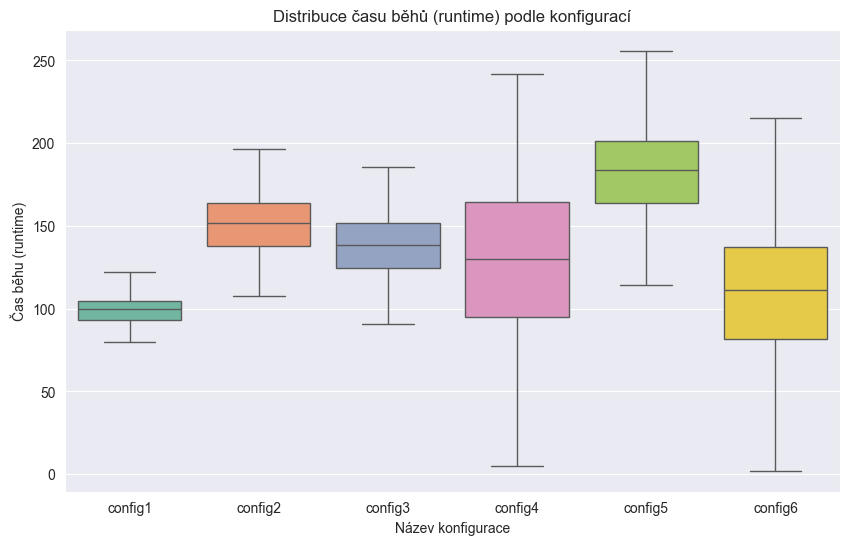

In [12]:
# Odstranění všech běhů, které nejsou success
wrong_data = df[df["status"] != "SUCCESS"]
wrong_data_indices = wrong_data.index
df = df.drop(index=wrong_data_indices)

# Odstranění outlierů
outliers = df.groupby("configuration", group_keys=False).apply(detect_outliers, include_groups=False)
outlier_indices = outliers.index
df = df.drop(index=outlier_indices)

plt.figure(figsize=(10, 6))
sns.boxplot(x="configuration", y="runtime", data=df, palette="Set2", hue="configuration")
plt.title("Distribuce času běhů (runtime) podle konfigurací")
plt.xlabel("Název konfigurace")
plt.ylabel("Čas běhu (runtime)")
plt.show()

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [13]:
dfstats = pd.DataFrame(df.groupby("configuration")["runtime"].describe())
dfstats

,count,mean,std,min,25%,50%,75%,max
configuration,,,,,,,,
config1,190.0,99.449016,8.866788,80.124311,93.034540,99.799944,104.737728,121.904556
config2,195.0,151.688034,18.583050,107.522086,138.003905,151.516091,163.764042,196.293171
config3,194.0,138.292420,19.393682,90.567110,124.769359,138.448002,151.501348,185.413857
config4,196.0,127.606156,50.282164,4.970286,94.793688,129.975246,164.327163,241.987620
config5,196.0,184.049441,28.276656,114.035821,164.072975,183.916111,201.255548,255.807973
config6,199.0,110.422689,40.875754,2.124534,81.656211,111.043642,137.554141,215.295283


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._
1) Název konfigurace
2) Počet běhů dané konfigurace
3) Průměrný čas běhu dané konfigurace
4) Směrodatnou odchylku běhů dané konfigurace
5) Minimální hodnotu času běhu ze všech běhů dané konfiguraci
6) 25% (první kvartil, Q1) času běhu všech běhů dané konfigurace
7) 50% (druhý kvartil, Q2) času běhu všech běhů dané konfigurace neboli medián
8) 75% (třetí kvartil, Q3) času běhu všech běhů dané konfigurace
6) Maximální hodnotu času běhů ze všech běhů dané konfiguraci

## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

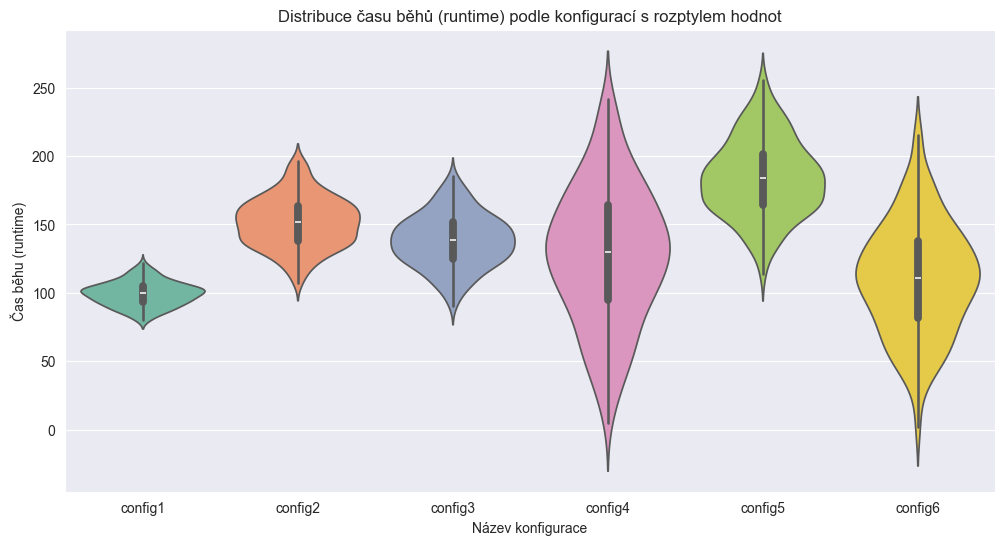

In [14]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="configuration", y="runtime", data=df, palette="Set2", hue="configuration", legend=False)
plt.title("Distribuce času běhů (runtime) podle konfigurací s rozptylem hodnot")
plt.xlabel("Název konfigurace")
plt.ylabel("Čas běhu (runtime)")
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

- Zvolil jsem houslový graf (violin plot) - oproti boxplots zobrazuje i hustotu dat, širší oblasti ukazují vyšší četnost hodnot, zatímco užší oblasti znamenají méně časté hodnoty.

- Zároveň stále tento typ grafu znázorňuje kvartily jednotlivých běhů (1. kvartil, 2. kvartil (medián) a 3. kvartil) - tlustá čára, minimum a maximum (konce svislé šedé čáry).

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. 

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

- Budeme zkoumat runtime jednotlivých konfigurací.
- Nejdříve provedeme shapiro test, kde zjistíme, zda bychom měli vyloučit, že jsou data normálně rozdělena. Již nyní ale můžeme předpokládat, že data jsou normálně rozdělena (na základě grafů výše).
- Dle grafů lze vidět (na základě mediánů a minimálních hodnot), že nejrychlejší konfigurace bude buď config1 nebo config6.
- Využijeme studentům t-test na všechny dvojice, pomocí p-hodnoty zamítneme/nezamítneme 0. hypotézu a pomocí statisitky t rozhodneme, která konfigurace je nejrychlejší.
- Config 1: variabilita: směrodatná odchylka = 8.866788 | poloha: průměr = 99.449016, medián = 99.799944, minimum: 80.124311, maximum: 121.904556
- Config 6: variabilita: směrodatná odchylka = 40.875754 | poloha: průměr = 110.422689, medián = 111.043642, minimum: 2.124534, maximum: 215.295283
- 0. hypotéza je: Mezi průměry času běhů daných dvou konfigurací není statisticky významný rozdíl.

In [15]:
shapiro_results = df.groupby("configuration")["runtime"].apply(stats.shapiro)
print("Výsledky shapio testu:")
print(shapiro_results, "\n")
# Všechny běhy konfigurace jsou normálně rozděleny. 0. hypotéza je, že jsou data normálně rozdělena, p-hodnoty (druhý sloupec, druhá hodnota) všech konfigurací shapiro testu jsou větší než 0,05 takže 0. hypotézu nezamítáme

config1_data = df[df["configuration"] == "config1"]["runtime"]
config6_data = df[df["configuration"] == "config6"]["runtime"]

# Provedení studentova t-testu
t_statistic, p_value = stats.ttest_ind(config1_data, config6_data)

alpha = 0.05 # hladina významnosti
if p_value < alpha:
    if t_statistic < 0:
        print("Rozdíl mezi konfiguracemi config1 a config6 je statisticky významný, config1 je rychlejší.")
    else:
        print("Rozdíl mezi konfiguracemi config1 a config6 je statisticky významný, config6 je rychlejší.")
else:
    print("Rozdíl mezi konfiguracemi config1 a config6 není statisticky významný.")


Výsledky shapio testu:
configuration
config1    (0.9918638017819146, 0.36605847080986026)
config2     (0.992530695344453, 0.42148105777568556)
config3     (0.9955148324414015, 0.8374173595659102)
config4     (0.9931968160110763, 0.5025231305724367)
config5     (0.9921460394014963, 0.3730437861605356)
config6     (0.9950868815162219, 0.7656591016112346)
Name: runtime, dtype: object 

Rozdíl mezi konfiguracemi config1 a config6 je statisticky významný, config1 je rychlejší.


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_
- Zamítáme 0. hypotézu, tzn. rozdíl mezi konfiguracemi je statisticky výzamný, statistická hodnota je záporná -> config1 je rychlejší.

### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [ ]:
def t_test_manual(config1, config2):
    n1 = len(config1)
    n2 = len(config2)
    mean1 = np.mean(config1)
    mean2 = np.mean(config2)
    std1 = np.std(config1, ddof=1)
    std2 = np.std(config2, ddof=1)

    # Pooled variance (sdružený rozptyl)
    s_pooled = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Standardní chyba rozdílu
    std_error = s_pooled * np.sqrt(1/n1 + 1/n2)

    t_statistic = (mean1 - mean2) / std_error

    # Počet stupňů volnosti
    df = n1 + n2 - 2

    p_value = 2 * stats.t.sf(abs(t_statistic), df)

    return t_statistic, p_value, df

t_statistic, p_value, _ = t_test_manual(config1_data, config6_data)
print("Výsledek vlastní imeplementace studentova t-testu:")
print(t_test_manual(config1_data, config6_data))
print("Výsledek knihovní funkce scipy.stats.ttest_ind studentova t-testu:")
print(stats.ttest_ind(config1_data, config6_data), "\n")

alpha = 0.05
if p_value < alpha:
    if t_statistic < 0:
        print("Rozdíl mezi konfiguracemi config1 a config6 je statisticky významný, config1 je rychlejší.")
    else:
        print("Rozdíl mezi konfiguracemi config1 a config6 je statisticky významný, config6 je rychlejší.")
else:
    print("Rozdíl mezi konfiguracemi config1 a config6 není statisticky významný.")

Výsledek vlastní imeplementace studentova t-testu:
(np.float64(-3.6199036194112146), np.float64(0.00033386487494703666), 387)
Výsledek knihovní funkce scipy.stats.ttest_ind studentova t-testu:
TtestResult(statistic=np.float64(-3.6199036194112146), pvalue=np.float64(0.00033386487494703666), df=np.float64(387.0)) 

Rozdíl mezi konfiguracemi config1 a config6 je statisticky významný, config1 je rychlejší.
